In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.linear_model import LassoCV
import ast
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd

from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.cm import ScalarMappable
import matplotlib.colors as mcolors
family_to_color = {
    'IL-1': '#2D2D2A',
    'IL-10': '#4C4C47',
    'IL-17': '#686E76',
    'IL-6/IL-12': '#848FA5',
    'IL-10 (IL-20 subfamily)': '#B9BFCB',
    'Interleukin - non-classified': '#DCDFE5',
    'Interferon': '#947E91',
    'Common γ chain/IL-13/TSLP': '#C14953',
    'TNF': '#D3938C',
    'Growth factor': '#E1C3B7',
    'Other': '#E5DCC5',
    
    'Common β chain': '#B76F52',
    'Chemokine': '#D0B4BC',
    'Complement': '#7F6B39'
}

/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/optuna/study/_optimize.py:29: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from optuna import progress_bar as pbar_module


In [2]:
output_dir = "/lustre/groups/ml01/workspace/ot_perturbation/figures/pbmc/data/donor_feature_importance"

In [18]:
data_dir = "/lustre/groups/ml01/workspace/ot_perturbation/data/pbmc/metrics_new_donor"
df = pd.read_csv(os.path.join(data_dir, "metrics_new_donor.csv"), index_col=0)

In [88]:

with open("/lustre/groups/ml01/workspace/ot_perturbation/data/pbmc/cyto_order.pkl", "rb") as file:
    cyto_order = pickle.load(file)

with open("/lustre/groups/ml01/workspace/ot_perturbation/data/pbmc/cyto_to_fam.pkl", "rb") as file:
    cyto_to_family = pickle.load(file)


In [5]:
df.head()

,mean_decoded_r_sq_per_cell_type,mean_e_distance_per_cell_type,mean_mmd_per_cell_type,mean_sdiv_10_per_cell_type,mean_sdiv_100_per_cell_type,mean_deg_r_sq_per_cell_type,mean_deg_e_distance_per_cell_type,mean_deg_mmd_per_cell_type,mean_deg_sdiv_10_per_cell_type,mean_deg_sdiv_100_per_cell_type,...,decoded_r_squared_pDC,e_distance_pDC,mmd_pDC,div_10_pDC,div_100_pDC,deg_decoded_r_squared_pDC,deg_e_distance_pDC,deg_mmd_pDC,deg_div_10_pDC,deg_div_100_pDC
Donor5_M-CSF,0.939229,18.962090,0.011942,107.454523,20.873164,0.803975,30.600798,0.047183,152.382869,27.255896,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Donor7_FasL,0.931790,23.716188,0.010927,96.702025,18.401584,0.820562,23.417112,0.043519,135.867084,19.631317,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Donor12_IL-32-beta,0.891522,30.378831,0.015021,112.437251,28.443358,0.602922,57.972663,0.058693,166.829876,42.230180,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Donor3_FasL,0.945373,7.198070,0.006927,83.716433,9.219070,0.867403,21.029513,0.049201,124.146561,19.256040,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Donor2_OX40L,0.929230,16.609110,0.009857,96.197410,16.496358,0.808503,24.007803,0.053788,132.870993,20.846540,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
def get_cytokine_importance(all_cytokines_in_train: list[str], df: pd.DataFrame, cytokine: str, target_variable: str = "ood_e_distance"):
    
    for d in all_cytokines_in_train:
        df_d[f"{d}_present"] = df_d.apply(lambda x: d in x["cytokine_in_train"], axis=1)

    for num_cytokines in df["num_cytokines_in_train"].unique():
        df_d[f"{num_cytokines}_present"] = df_d.apply(lambda x: x["num_cytokines_in_train"] == num_cytokines, axis=1)
    
    cols = [f"{d}_present" for d in all_cytokines_in_train] + [f"{num_cytokines}_present" for num_cytokines in df_d["num_cytokines_in_train"].unique()]
    # Prepare feature matrix and target variable
    X = df_d[cols]
    y = df_d[target_variable]
    
    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Fit Lasso regression
    lasso = LassoCV(cv=2, random_state=0)
    lasso.fit(X_scaled, y)
    
    # Extract coefficients
    coefficients = lasso.coef_
    intercept = lasso.intercept_
    
    # Create a DataFrame with feature importance
    feature_stats = pd.DataFrame({
        'Feature': cols,
        'Coefficient': coefficients
    }).sort_values(by='Coefficient', ascending=False)
    
    # Add the intercept for completeness
    feature_stats.loc[len(feature_stats)] = ['Intercept', intercept]
    
    return feature_stats



In [31]:
all_cytokines_in_test = df["cytokine"].unique()

all_cytokines_in_train = list(
        set(el for i in range(len(df)) for el in ast.literal_eval(df.iloc[i]["cytokine_in_train"]))
    )

cytokine_cols = [f"{d}_present" for d in all_cytokines_in_train] + [f"{num_cytokines}_present" for num_cytokines in df["num_cytokines_in_train"].unique()]


In [41]:

train_cytos_ordered = [f"{el}_present" for el in cyto_order if el in all_cytokines_in_train]
test_cytos_ordered = [el for el in cyto_order if el in all_cytokines_in_test]
df_c = pd.DataFrame(columns=cytokine_cols)
for cytokine in all_cytokines_in_test:
    filtered_df = df[df["cytokine"]==cytokine]
    lower_bound = filtered_df["ood_e_distance"].quantile(0.0)
    upper_bound = filtered_df["ood_e_distance"].quantile(0.95)
    filtered_df = filtered_df[(filtered_df["ood_e_distance"] >= lower_bound) & (filtered_df["ood_e_distance"] <= upper_bound)]
    d = get_cytokine_importance(all_cytokines_in_train, filtered_df, cytokine).set_index("Feature")
    d.loc[f"{cytokine}_present"] = None
    df_c.loc[cytokine] = d.loc[cytokine_cols]["Coefficient"]

df_c = df_c.loc[test_cytos_ordered, train_cytos_ordered]

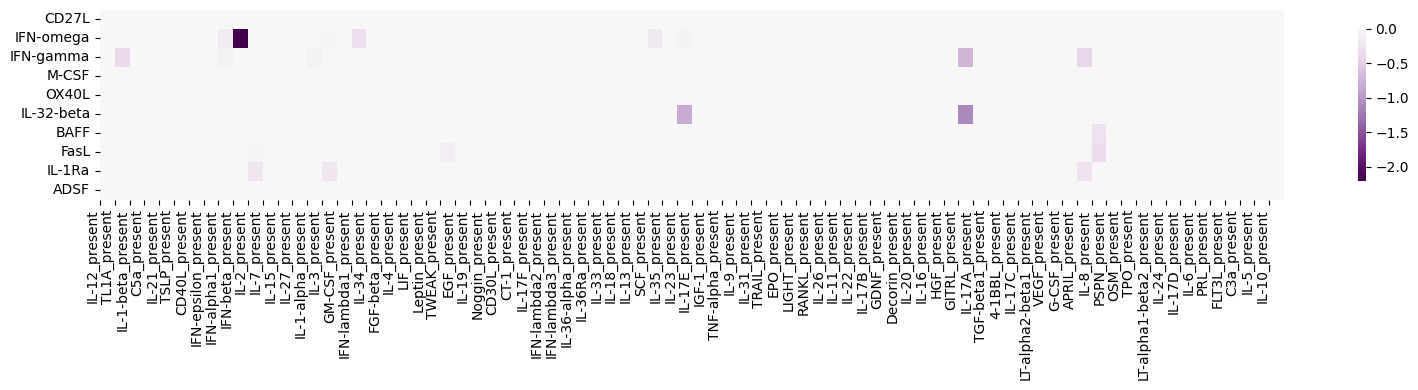

<Figure size 640x480 with 0 Axes>

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 4))
sns.heatmap(
    df_c,
    cmap="PRGn",            
    center=0,                  # Set 0 as the midpoint of the colormap
    linecolor='white',         # Use white borders between cells
    cbar_kws={'shrink': 0.8}   # Shrink the colorbar
)

# Ensure all x-tick labels are shown
plt.xticks(
    ticks=range(len(df_c.columns)),  # Create ticks for all columns
    labels=df_c.columns,            # Use column names as labels
    rotation=90,                    # Rotate labels for better readability
    ha='right'                      # Align labels to the right
)

# Show the plot
plt.tight_layout()
plt.show()
plt.savefig(os.path.join(output_dir, "new_donor_feature_importance.pdf"), format="pdf", bbox_inches="tight")



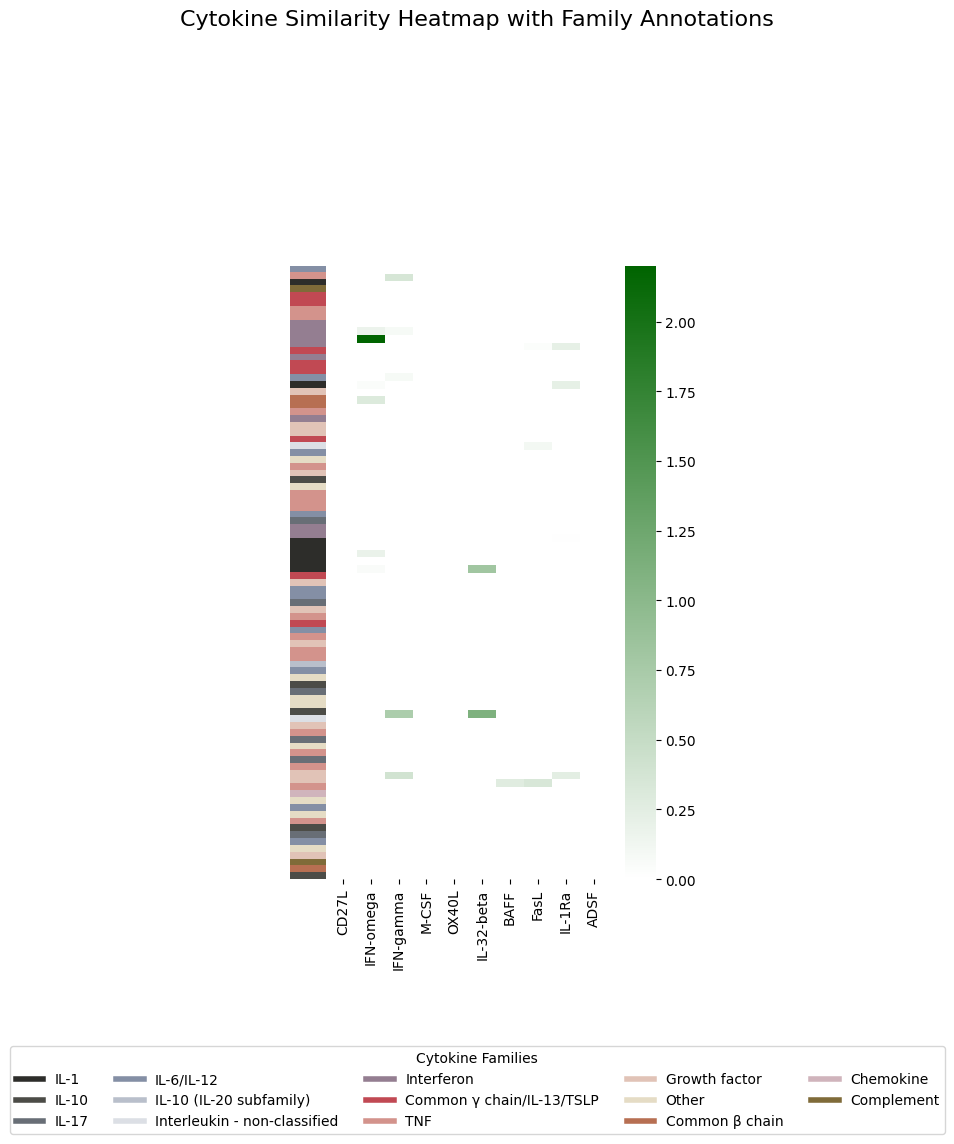

In [114]:


family_to_color = {k: mcolors.to_rgb(v) for k,v in family_to_color.items()}

# Map cytokines to colors
row_colors = [[family_to_color[cyto_to_family[cyto]]] for cyto in cyto_order]

# Set up the grid
fig = plt.figure(figsize=(5, 10))
grid = fig.add_gridspec(5, 10, wspace=0.1, hspace=0.1)

white_to_green = LinearSegmentedColormap.from_list("white_to_green", ["white", "darkgreen"])

# Normalize the data values for the colormap
norm = Normalize(vmax=-df_c.min().min(), vmin=-df_c.max().max())
sm = ScalarMappable(cmap=white_to_green, norm=norm)
sm.set_array([])  # Required for the colorbar

# Map the normalized colors to the data
colors = sm.to_rgba(df_ranks["rank"])



# Main heatmap
ax_main = fig.add_subplot(grid[1:, 1:])
sns.heatmap(
    -df_c.T,
    cmap=white_to_green,
    xticklabels=True,
    yticklabels=False,
    ax=ax_main,
)

# Row color bar
ax_row_colors = fig.add_subplot(grid[1:, 0])
ax_row_colors.imshow(row_colors, aspect="auto")
ax_row_colors.axis("off")

# Add legend
legend_elements = [
    plt.Line2D([0], [0], color=color, lw=4, label=family)
    for family, color in family_to_color.items()
]
fig.legend(
    handles=legend_elements,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.05),
    ncol=5,
    title="Cytokine Families",
)

# Add a title
fig.suptitle("Cytokine Similarity Heatmap with Family Annotations", fontsize=16)
plt.savefig(os.path.join(output_dir, "new_donor_feature_importance_family_annotation.pdf"), format="pdf", bbox_inches="tight")

plt.show()

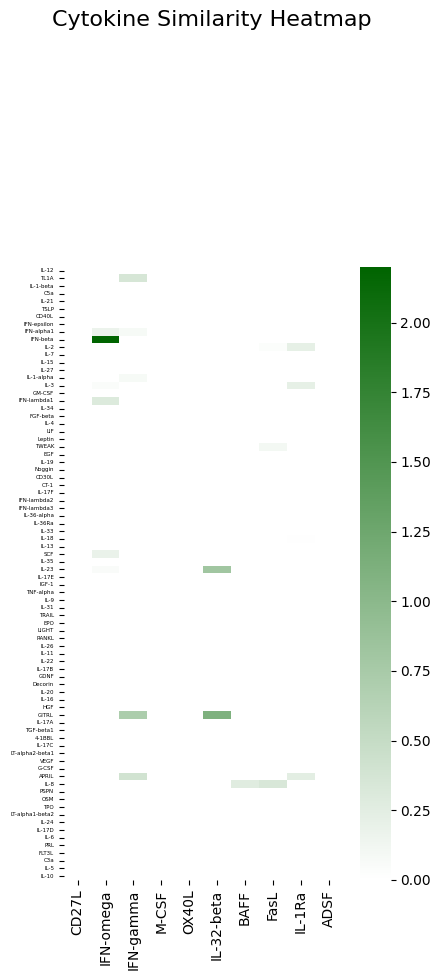

In [120]:
# Set up the grid
fig = plt.figure(figsize=(5, 10))
grid = fig.add_gridspec(5, 10, wspace=0.1, hspace=0.1)

# Custom colormap: white to dark green
white_to_green = LinearSegmentedColormap.from_list("white_to_green", ["white", "darkgreen"])

# Normalize the data values for the colormap
norm = Normalize(vmax=-df_c.min().min(), vmin=-df_c.max().max())
sm = ScalarMappable(cmap=white_to_green, norm=norm)
sm.set_array([])  # Required for the colorbar

# Preprocess y-axis labels to remove "_present"
yticks = [label.replace("_present", "") for label in df_c.columns]

# Main heatmap
ax_main = fig.add_subplot(grid[1:, 1:])
sns.heatmap(
    -df_c.T,
    cmap=white_to_green,
    xticklabels=True,
    yticklabels=yticks,
    ax=ax_main
)

# Reduce y-axis label size
ax_main.tick_params(axis="y", labelsize=4)

# Add a title
fig.suptitle("Cytokine Similarity Heatmap", fontsize=16)

# Save the figure
plt.savefig(os.path.join(output_dir, "new_donor_feature_importance.pdf"), format="pdf", bbox_inches="tight")

plt.show()


In [121]:
negative_entries = {
    (row_name, col_name): df_c.loc[row_name, col_name]
    for row_name in df_c.index
    for col_name in df_c.columns
    if df_c.loc[row_name, col_name] < -0.0001
}

In [122]:
negative_entries

{('IFN-omega', 'IFN-alpha1_present'): -0.16646590449465376,
 ('IFN-omega', 'IFN-beta_present'): -2.2001990206826685,
 ('IFN-omega', 'IL-3_present'): -0.04431157608809741,
 ('IFN-omega', 'IFN-lambda1_present'): -0.3087746884945674,
 ('IFN-omega', 'SCF_present'): -0.18890535385398935,
 ('IFN-omega', 'IL-23_present'): -0.05235481991898037,
 ('IFN-gamma', 'TL1A_present'): -0.3562633547142873,
 ('IFN-gamma', 'IFN-alpha1_present'): -0.08044880981209843,
 ('IFN-gamma', 'IL-1-alpha_present'): -0.080718045399411,
 ('IFN-gamma', 'GITRL_present'): -0.7145651404876091,
 ('IFN-gamma', 'APRIL_present'): -0.402241522989921,
 ('IL-32-beta', 'IL-23_present'): -0.8116328526851045,
 ('IL-32-beta', 'GITRL_present'): -1.1099595383983998,
 ('BAFF', 'IL-8_present'): -0.27164464723948434,
 ('FasL', 'IL-2_present'): -0.04204566641712372,
 ('FasL', 'TWEAK_present'): -0.1083966051172412,
 ('FasL', 'IL-8_present'): -0.3407935547258676,
 ('IL-1Ra', 'IL-2_present'): -0.22058458547902335,
 ('IL-1Ra', 'IL-3_present')

In [123]:
data_sim_dir  = "/lustre/groups/ml01/workspace/ot_perturbation/data/pbmc/similarities"
df_sim = pd.read_csv(os.path.join(data_sim_dir, "df_cytokine_sim.csv"), index_col=0)

In [124]:
df_sim.head()

,FasL,IL-3,RANKL,FLT3L,IL-2,IL-17F,EPO,IL-11,Decorin,IFN-lambda3,...,IL-36-alpha,IFN-alpha1,FGF-beta,IL-1-alpha,IL-1-beta,IFN-beta,TNF-alpha,IFN-lambda2,IFN-epsilon,TGF-beta1
FasL,1.000001,-0.088335,0.268296,0.139591,-0.117389,0.638344,0.226422,0.122213,0.354636,-0.048111,...,0.018876,-0.092534,0.231204,-0.120410,0.001044,-0.089532,0.161505,0.534423,0.614388,0.199367
IL-3,-0.088335,1.000000,-0.011184,-0.126756,0.382146,0.028150,-0.032443,0.065129,0.041368,0.218166,...,0.408902,0.184334,0.017756,0.520522,0.282708,0.180848,-0.178252,0.096185,0.085638,-0.062736
RANKL,0.268296,-0.011184,1.000001,0.407852,0.026537,0.244008,0.335682,0.490832,0.448160,0.137616,...,0.133890,-0.012369,-0.176287,0.023303,-0.138374,-0.015088,0.495903,0.111510,0.135083,0.105677
FLT3L,0.139591,-0.126756,0.407852,1.000001,-0.126805,0.286963,0.244183,0.182227,0.318962,0.148480,...,-0.007066,-0.107486,-0.088964,-0.185815,-0.176019,-0.126892,0.565745,0.023849,-0.110374,0.212196
IL-2,-0.117389,0.382146,0.026537,-0.126805,1.000001,0.044929,-0.139009,0.167407,0.075645,0.420502,...,0.230248,0.672628,-0.120587,0.614346,0.635659,0.733531,-0.106739,0.102880,0.266860,-0.167866


In [125]:
df_sim["cyto1"] = df_sim.index
df_sim = df_sim[df_sim["cyto1"].isin(all_cytokines_in_test)]
df_sim_long = pd.melt(df_sim, id_vars=["cyto1"], var_name="cyto2", value_name="similarity")

In [126]:
df_sim_long = df_sim_long[(df_sim_long["cyto1"]!=df_sim_long["cyto2"]) & (df_sim_long["cyto2"]!="cyto")]

In [127]:
df_sim_long

,cyto1,cyto2,similarity
1,CD27L,FasL,0.707464
2,BAFF,FasL,0.469407
3,OX40L,FasL,0.069370
4,M-CSF,FasL,-0.225516
5,ADSF,FasL,0.278258
...,...,...,...
895,ADSF,TGF-beta1,0.205035
896,IFN-omega,TGF-beta1,-0.055303
897,IL-1Ra,TGF-beta1,0.000014
898,IL-32-beta,TGF-beta1,0.027636


In [128]:
df_sim_long = df_sim_long.sort_values("similarity", ascending=False)

In [129]:
df_sim_long["rank"] = np.arange(len(df_sim_long))

In [130]:
sim_rank = {}
for cyto1, cyto2 in negative_entries.keys():
    sim_rank[(cyto1, cyto2)] = df_sim_long[(df_sim_long["cyto1"]==cyto1) & (df_sim_long["cyto2"]==cyto2.split("_")[0])]["rank"].values

In [131]:
sim_rank.values()

dict_values([array([5]), array([0]), array([248]), array([68]), array([478]), array([345]), array([195]), array([6]), array([32]), array([788]), array([475]), array([484]), array([294]), array([846]), array([802]), array([60]), array([843]), array([719]), array([202]), array([14]), array([219])])

In [132]:
sim_rank

{('IFN-omega', 'IFN-alpha1_present'): array([5]),
 ('IFN-omega', 'IFN-beta_present'): array([0]),
 ('IFN-omega', 'IL-3_present'): array([248]),
 ('IFN-omega', 'IFN-lambda1_present'): array([68]),
 ('IFN-omega', 'SCF_present'): array([478]),
 ('IFN-omega', 'IL-23_present'): array([345]),
 ('IFN-gamma', 'TL1A_present'): array([195]),
 ('IFN-gamma', 'IFN-alpha1_present'): array([6]),
 ('IFN-gamma', 'IL-1-alpha_present'): array([32]),
 ('IFN-gamma', 'GITRL_present'): array([788]),
 ('IFN-gamma', 'APRIL_present'): array([475]),
 ('IL-32-beta', 'IL-23_present'): array([484]),
 ('IL-32-beta', 'GITRL_present'): array([294]),
 ('BAFF', 'IL-8_present'): array([846]),
 ('FasL', 'IL-2_present'): array([802]),
 ('FasL', 'TWEAK_present'): array([60]),
 ('FasL', 'IL-8_present'): array([843]),
 ('IL-1Ra', 'IL-2_present'): array([719]),
 ('IL-1Ra', 'IL-3_present'): array([202]),
 ('IL-1Ra', 'IL-18_present'): array([14]),
 ('IL-1Ra', 'APRIL_present'): array([219])}

In [134]:
neg_entries_rank = {}
for test_cyto in all_cytokines_in_test:
    df_tmp = df_sim_long[df_sim_long["cyto1"]==test_cyto]
    df_tmp = df_tmp[df_tmp["cyto2"].isin(all_cytokines_in_train)]
    df_tmp = df_tmp.sort_values("similarity", ascending=True)
    df_tmp["rank"] = np.arange(len(df_tmp)) + 1
    neg_entries_tmp = {k:v for k,v in negative_entries.items() if test_cyto==k[0]}
    for expl_cyto in neg_entries_tmp.keys():
        neg_entries_rank[expl_cyto] = df_tmp[df_tmp["cyto2"]==expl_cyto[1].split("_")[0]]["rank"].values

In [135]:
neg_entries_rank = {f"{k[0]}_{k[1]}": int(v) for k,v in neg_entries_rank.items()}

/tmp/ipykernel_1477247/2932303600.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  neg_entries_rank = {f"{k[0]}_{k[1]}": int(v) for k,v in neg_entries_rank.items()}


In [151]:
neg_entries_f = {f"{k[0]}_{k[1]}": v for k,v in negative_entries.items()}
df_feature_imp = pd.DataFrame.from_dict(neg_entries_f, orient="index", columns=["feature_importance"])

In [153]:
df_feature_imp.head()

,feature_importance
IFN-omega_IFN-alpha1_present,-0.166466
IFN-omega_IFN-beta_present,-2.200199
IFN-omega_IL-3_present,-0.044312
IFN-omega_IFN-lambda1_present,-0.308775
IFN-omega_SCF_present,-0.188905


In [136]:
df_ranks = pd.DataFrame.from_dict(neg_entries_rank, orient="index", columns=["rank"])

In [137]:
df_ranks["cyto_comb"] = df_ranks.index

In [138]:
df_sim_long["cyto_1_2"] = df_sim_long.apply(lambda x: x["cyto1"] + "_"+x["cyto2"]+"_present", axis=1)

In [139]:
df_sim_long = df_sim_long.set_index("cyto_1_2")

In [160]:
df_ranks["feature_importance"] = -df_feature_imp["feature_importance"]

In [161]:
df_ranks.head()

,rank,cyto_comb,feature_importance
IL-1Ra_IL-18_present,80,IL-1Ra_IL-18_present,0.011192
FasL_IL-2_present,6,FasL_IL-2_present,0.042046
IFN-omega_IL-3_present,63,IFN-omega_IL-3_present,0.044312
IFN-omega_IL-23_present,59,IFN-omega_IL-23_present,0.052355
IFN-gamma_IFN-alpha1_present,78,IFN-gamma_IFN-alpha1_present,0.080449


In [164]:
df_ranks = df_ranks.sort_values("rank", ascending=False)

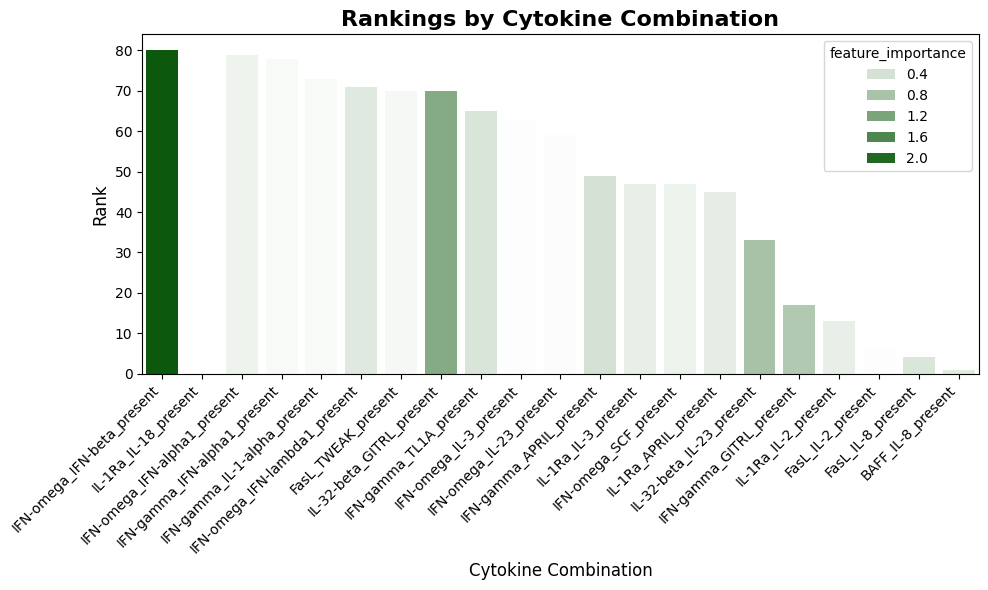

In [169]:
import seaborn as sns
import matplotlib.pyplot as plt

white_to_green = LinearSegmentedColormap.from_list("white_to_green", ["white", "darkgreen"])

# Normalize the data values for the colormap
norm = Normalize(vmax=-df_c.min().min(), vmin=-df_c.max().max())
sm = ScalarMappable(cmap=white_to_green, norm=norm)
sm.set_array([])  # Required for the colorbar


# Example of an improved bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df_ranks, x="cyto_comb", y="rank", hue="feature_importance", palette=white_to_green)

# Customizing the plot
plt.title("Rankings by Cytokine Combination", fontsize=16, weight="bold")
plt.xlabel("Cytokine Combination", fontsize=12)
plt.ylabel("Rank", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)  # Rotating x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels

# Display the plot
plt.show()


In [166]:
df_ranks.to_csv("/lustre/groups/ml01/workspace/ot_perturbation/data/pbmc/metrics_new_donor_analysis/df_ranks.csv")

In [146]:
df_ranks.sort_values("feature_importance")

,rank,cyto_comb,feature_importance
BAFF_IL-8_present,1,BAFF_IL-8_present,-0.156517
FasL_IL-8_present,4,FasL_IL-8_present,-0.150898
FasL_IL-2_present,6,FasL_IL-2_present,-0.117389
IFN-gamma_GITRL_present,17,IFN-gamma_GITRL_present,-0.101142
IL-1Ra_IL-2_present,13,IL-1Ra_IL-2_present,-0.053447
IL-32-beta_IL-23_present,33,IL-32-beta_IL-23_present,0.087355
IFN-omega_SCF_present,47,IFN-omega_SCF_present,0.089972
IFN-gamma_APRIL_present,49,IFN-gamma_APRIL_present,0.090633
IFN-omega_IL-23_present,59,IFN-omega_IL-23_present,0.156005
IL-32-beta_GITRL_present,70,IL-32-beta_GITRL_present,0.182119
